# Changes in CB1 receptor availability in PTSD 

There are conflicting evidence regarding the role of CB1 receptors in PTSD. 

Using the 11c-Omar Radiotracer here we aim to compare differences between healthy controls and PTSD in CB1 receptor availability.

CB1 recptors are the most common g-coupled receptors in the brain and are expressed in all regions of the brain.

Thus, we first ran an analysis to look at differences between the group in the all brain.

Previous studies have pointed to age and sex differences in CB1 receptor expression, hence, both age and sex were interduced as covariance in a one way ANVCOVA.

Using OLS regression, we will verify the effects, and check for which model describe the data best by comparing AIC and BIC.

In the next stage we will check for correlation between CB1 receptor availability and PTSD symptoms.

In the final stage we will look at the Amygdala as an a-priori ROI and look at how CB1 receptors in the Amygdala controling for age, sex, and the whole brain signal correlate with PTSD symptoms.

## Loading libraries

In [1]:
import pandas as pd
from glob import glob

import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

# Load data and prepare it for analysis

In [2]:
# Gather VT data from storage@Yale 

hc_path = '/media/Data/Lab_Projects/CB1/neuroimaging/CB1_results/OMAR_scores/dcd/HC/*/batch_omar_doneon_*.csv'

db = pd.DataFrame()

for sub in glob(hc_path):
    temp = pd.read_csv(sub)
    temp = temp[temp['Parameter']== 'VT']
    subID = temp.PatientID[0]
    temp = temp[['ROI', 'Value']]
    temp = temp.rename(columns={'Value': subID})
    temp = temp.set_index('ROI')
    temp = temp.T
    db = db.append(temp)
    
db['group'] = 'HC'

In [3]:
# Load the PTSD data including the clinical data.

PTSD = pd.read_csv('CB1_clinical_30_6_21.csv')
PTSD = PTSD.set_index('PetID')
PTSD = PTSD[PTSD['PTSD'] == 'Yes']

PTSD_bg = PTSD.iloc[:, 11:]
PTSD_bg['group'] = 'PTSD'

db = db.append(PTSD_bg)

In [4]:
# get age and gender as recorded in the Haven data base

age = pd.read_csv('/home/nachshon/Documents/CB1/PETdata/age.csv')
age = age.set_index('PatientID')
data = db.merge(age , left_index=True, right_index=True)

In [5]:
# based on average ROI volume in mm3 caculate whole brain signal
data['whole_brain'] = data.frontal*0.39 + data.temporal*0.265 + data.occipital*0.126 + data.cerebellum*0.11 + data.parietal*0.109
PTSD['whole_brain'] = PTSD.frontal*0.39 + PTSD.temporal*0.265 + PTSD.occipital*0.126 + PTSD.cerebellum*0.11 + PTSD.parietal*0.109

# include only relevant fields for streamlining analysis
wb = data[['group', 'sex', 'age','whole_brain']]
wb['Sex'] = wb['sex'].map({'f':1, 'm':0})
wb = wb.drop_duplicates()

/tmp/ipykernel_394195/814747095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb['Sex'] = wb['sex'].map({'f':1, 'm':0})


## Sample description

In [6]:
wb[['group','sex','age']].groupby(['group','sex']).count()

age
group sex     
HC    f      7
      m     21
PTSD  f      7
      m      6

In [7]:
wb.groupby(['group'], as_index=False).agg(['mean','std'])

age            whole_brain                 Sex          
            mean        std        mean       std      mean       std
group                                                                
HC     28.750000  10.644508    1.521542  0.206936  0.250000  0.440959
PTSD   42.307692  13.567023    1.283803  0.211652  0.538462  0.518875

In [8]:
wb.groupby(['sex'], as_index=False).agg(['mean','std'])

age            whole_brain            Sex     
          mean        std        mean       std mean  std
sex                                                      
f    33.000000  13.817492    1.448039  0.289559  1.0  0.0
m    33.074074  13.035236    1.445188  0.206202  0.0  0.0

The descriptive show that the PTSD group are much older than the HC.

It looks as no difference between females and males in age or CB1 receptor availability.

The female/male ratio is higher in the PTSD. This is more representative of the general population than veterans.

## Analysis of the Age effects

In [9]:
pg.corr(wb.age, wb.whole_brain, method='bicor')

,n,r,CI95%,p-val,power
bicor,41,-0.39486,"[-0.63, -0.1]",0.010622,0.739278


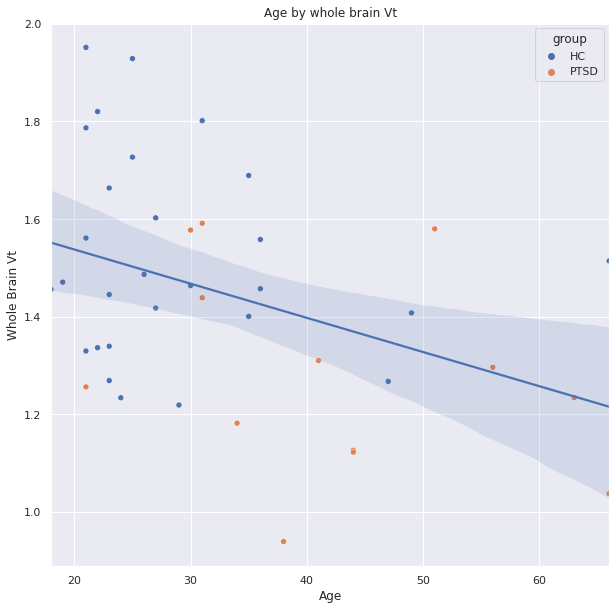

In [10]:
# Plot the relation between Age and CB1 receptor avilability 

sns.scatterplot(x = 'age', y = 'whole_brain', 
                data = wb, hue = 'group').set(title='Age by whole brain Vt', 
                                             xlabel=None, ylabel =None)
    
sns.regplot(x = 'age', y = 'whole_brain', data = wb, scatter=False).set(xlabel="Age", ylabel="Whole Brain Vt")
    
plt.show()

There is a significant correlation between age and Vt. Hence Age will be used as a covariate in all future analysis

# Analysis of the differences between PTSD and HC

In [11]:
pg.ancova(data=wb, dv='whole_brain', covar=['age','Sex'], between='group')

,Source,SS,DF,F,p-unc,np2
0,group,0.267657,1,6.231030,0.017136,0.144133
1,age,0.056845,1,1.323339,0.257375,0.034531
2,Sex,0.030653,1,0.713595,0.403682,0.018921
3,Residual,1.589355,37,NaN,NaN,NaN


[Text(0.5, 0, ''), Text(0, 0.5, 'Whole Brain Vt')]

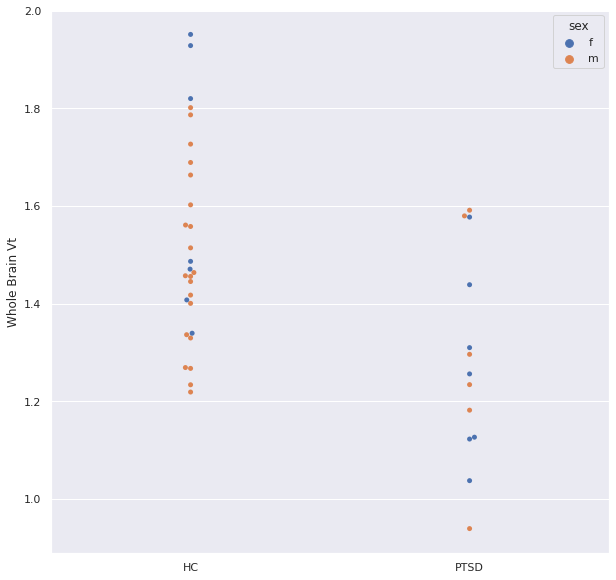

In [12]:
sns.swarmplot(x = 'group', y = 'whole_brain', data = wb, hue="sex").set(xlabel=None, ylabel="Whole Brain Vt")

There is a strong reduction in the expression of CB1r in the PTSD group. This is controlling for both age and sex.

To verify this result and look at the contribution of age and sex, 3 OLS models were used. 

Using AIC and BIC to compare models we will asses the fit to the data.

## OLS analysis


In [13]:
m1 = smf.ols(formula='whole_brain ~ group', data=wb)
m2 = smf.ols(formula='whole_brain ~ group + age', data=wb)
m3 = smf.ols(formula='whole_brain ~ group + age + sex', data=wb)
    
m1f = m1.fit()
m2f = m2.fit()
m3f = m3.fit()

In [14]:
print(m1f.summary())
print(m2f.summary())
print(m3f.summary())

                            OLS Regression Results                            
Dep. Variable:            whole_brain   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     11.55
Date:                Wed, 26 Jan 2022   Prob (F-statistic):            0.00157
Time:                        23:49:01   Log-Likelihood:                 7.1492
No. Observations:                  41   AIC:                            -10.30
Df Residuals:                      39   BIC:                            -6.871
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5215      0.039     38.634

All models show a significant reduction in CB1r in the PTSD group p< 0.002-0.017. 

While the model without age or sex shows the best fit to the data, age is correlated with Vt and should be consider as an important covariate.

## Correlation between Whole brain Vt and PTSD symptoms

In [15]:
pg.partial_corr(data=PTSD, x='whole_brain', y ='Total', covar=['age'])

,n,r,CI95%,p-val
pearson,13,0.215866,"[-0.41, 0.7]",0.500419


No significant correlation between global signal and PTSD symptoms

## Correlation between Amygdala CB1r and PTSD symptoms

as an a-priori analysis we choose to focus on the Amygdala. 

In [16]:
pg.partial_corr(data=PTSD, x='amygdala', y ='Total', covar=['age', 'whole_brain'])

,n,r,CI95%,p-val
pearson,13,0.609846,"[0.02, 0.89]",0.04635


<AxesSubplot:xlabel='Amygdala Vt', ylabel='Totsl Symptoms'>

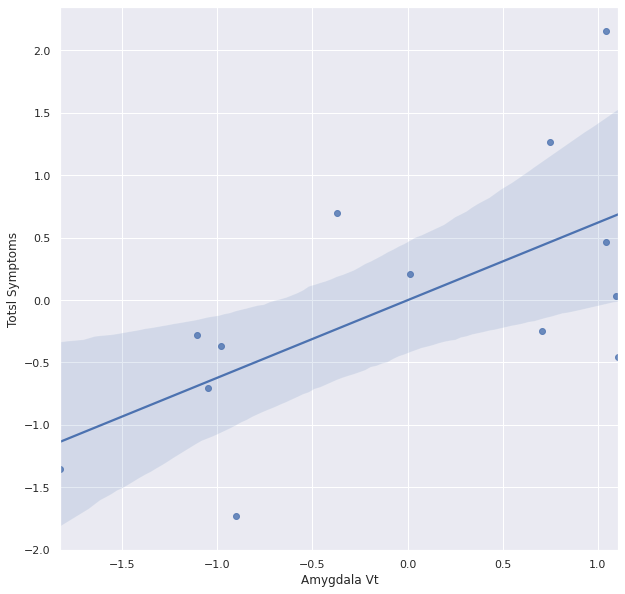

In [17]:
X = PTSD[['whole_brain', 'age']]   # independent variables
y = PTSD['amygdala']   # dependent variables

# add intercept
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

PTSD['Amygdala Vt'] = influence.resid_studentized_internal

X = PTSD[[ 'whole_brain', 'age']]   # independent variables
y = PTSD['Total']   # dependent variables

# add intercept
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

PTSD['Totsl Symptoms'] = influence.resid_studentized_internal

sns.regplot(x = 'Amygdala Vt', y = 'Totsl Symptoms', data = PTSD)